In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
!pip install --upgrade wandb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.



  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=fe986a535a883d7471c7441e3f41975e6acb9cd9a82f477ae2cbb5db7dd5ea21
  Stored in directory: c:\users\gefre\appdata\local\pip\cache\wheels\29\93\c6\762e359f8cb6a5b69c72235d798804cae523bbe41c2aa8333d
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6488 sha256=7fdbe8ff1e2f5cad9f1116fd1d572a77a370347f5ac3d5bab305df059f034b64
  Stored in directory: c:\users\gefre\appdata\local\pip\cache\wheels\50\ca\fa\8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
Successfully built promise subprocess32
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.4
    Uninstalling urllib3-1.26.4:
      Successfully uninstalled urllib3-1.26.4


In [2]:
import wandb

from matplotlib import pyplot as plt
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
from dataset import Dataset
from models import UNet
from trainer import Trainer
from utils import accuracy
from utils import save_predictions_as_imgs
from utils import hard_dice
from utils import DiceLoss
from utils import make_blending
from utils import BCEDiceLoss
from utils import read_mask

In [4]:
wandb.login()

wandb: Currently logged in as: emorh (use `wandb login --relogin` to force relogin)


True

In [13]:
train_folder = 'train'
val_folder = 'val'
batch_size = 1
device = 'cuda'

train_transforms = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.Rotate(limit=10, p=1),    
        A.ChannelShuffle(),
        A.Normalize(),
        ToTensorV2()
    ])

val_transforms = A.Compose(
    [   
        A.Resize(height=512, width=512),
        ToTensorV2()
    ])

train_dataset = Dataset(train_folder, train_transforms)
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size, pin_memory=True, shuffle=True)

val_dataset = Dataset(val_folder, val_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, pin_memory=True, shuffle=True)

In [14]:
hyperparametrs = {
    'n_filters': 32,
    'loss_weight': 0.8,
    'lr': 1e-3,
    'epochs': 50,
    'lr_reduce_rate': 0.5,
    'patience': 4,
    'early_stopping': 50, # пока уберем раннюю остановку
}

with wandb.init(project='segmentation project', config=hyperparametrs):
    config = wandb.config
    model = UNet(n_filters=config['n_filters'])
    criterion = BCEDiceLoss(config['loss_weight'])
    metric = [('accuracy', accuracy), ('dice', hard_dice)]
    trainer = Trainer(model, criterion, metric, config)
    trainer.fit(train_loader, val_loader)

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████| 244/244 [01:40<00:00,  2.44it/s]


train metrics: accuracy: 87.82688 dice: 0.87285 loss: 0.20863


Epoch 1:   0%|                                                                                 | 0/244 [00:00<?, ?it/s]

0.001
val metrics: accuracy: 86.16594 dice: 0.82142 loss: 0.23808


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 244/244 [01:42<00:00,  2.39it/s]


train metrics: accuracy: 89.02309 dice: 0.88650 loss: 0.16874


Epoch 2:   0%|                                                                                 | 0/244 [00:00<?, ?it/s]

0.001
val metrics: accuracy: 81.68242 dice: 0.71569 loss: 0.34515


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 244/244 [01:58<00:00,  2.06it/s]


train metrics: accuracy: 89.26320 dice: 0.88862 loss: 0.16431
0.001
val metrics: accuracy: 84.95068 dice: 0.84708 loss: 0.23912


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 244/244 [01:56<00:00,  2.09it/s]


train metrics: accuracy: 89.38373 dice: 0.89009 loss: 0.16209


Epoch 4:   0%|                                                                                 | 0/244 [00:00<?, ?it/s]

0.001
val metrics: accuracy: 86.34397 dice: 0.82545 loss: 0.24878


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 244/244 [01:44<00:00,  2.34it/s]


train metrics: accuracy: 89.54198 dice: 0.89121 loss: 0.15935


Epoch 5:   0%|                                                                                 | 0/244 [00:00<?, ?it/s]

0.001
val metrics: accuracy: 84.68730 dice: 0.80332 loss: 0.27458


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 244/244 [01:46<00:00,  2.29it/s]


train metrics: accuracy: 90.12425 dice: 0.89739 loss: 0.14977


Epoch 6:   0%|                                                                                 | 0/244 [00:00<?, ?it/s]

0.001
val metrics: accuracy: 84.52172 dice: 0.78966 loss: 0.28336


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 244/244 [01:47<00:00,  2.26it/s]


train metrics: accuracy: 90.29558 dice: 0.89874 loss: 0.14690


Epoch 7:   0%|                                                                                 | 0/244 [00:00<?, ?it/s]

0.001
val metrics: accuracy: 88.45274 dice: 0.87040 loss: 0.18299


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 244/244 [01:43<00:00,  2.37it/s]


train metrics: accuracy: 90.29347 dice: 0.89904 loss: 0.14690


Epoch 8:   0%|                                                                                 | 0/244 [00:00<?, ?it/s]

0.001
val metrics: accuracy: 88.89947 dice: 0.87554 loss: 0.18056


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 244/244 [01:42<00:00,  2.39it/s]


train metrics: accuracy: 90.71338 dice: 0.90277 loss: 0.14114


Epoch 9:   0%|                                                                                 | 0/244 [00:00<?, ?it/s]

0.001
val metrics: accuracy: 88.02762 dice: 0.84445 loss: 0.22236


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 244/244 [01:42<00:00,  2.37it/s]


train metrics: accuracy: 90.69009 dice: 0.90260 loss: 0.14066


Epoch 10:   0%|                                                                                | 0/244 [00:00<?, ?it/s]

0.001
val metrics: accuracy: 89.49089 dice: 0.88327 loss: 0.16607


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 244/244 [01:58<00:00,  2.06it/s]


train metrics: accuracy: 90.97052 dice: 0.90580 loss: 0.13634


Epoch 11:   0%|                                                                                | 0/244 [00:00<?, ?it/s]

0.001
val metrics: accuracy: 87.51260 dice: 0.83678 loss: 0.23361


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 244/244 [01:53<00:00,  2.15it/s]


train metrics: accuracy: 90.92570 dice: 0.90592 loss: 0.13655


Epoch 12:   0%|                                                                                | 0/244 [00:00<?, ?it/s]

0.001
val metrics: accuracy: 88.02893 dice: 0.84601 loss: 0.21980


Epoch 12:  88%|█████████████████████████████████████████████████████████████▋        | 215/244 [01:36<00:13,  2.23it/s]


accuracy,88.02893
_runtime,2009
_timestamp,1626180524
_step,36
dice,0.84601
loss,0.2198


accuracy,▅▁▄▅▄▄▇▇▇█▆▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
dice,▅▁▆▆▅▄▇█▆█▆▆
loss,▄█▄▄▅▆▂▂▃▁▄▃


KeyboardInterrupt: 

In [136]:
model.load_state_dict(torch.load(os.path.join(Trainer.CHECKPOINTS_PATH, 'weights.pth')))
save_predictions_as_imgs(val_loader, model)

In [123]:
def show_images_with_mask(number, model_mask=False):
    img_path = './saved_images/orig_' + str(number) + '.png'
    mask_path = ''
    if model_mask == False:
        mask_path = './saved_images/' + str(number) + '.png'
    else:
        mask_path = './saved_images/pred_' + str(number) + '.png'
    plt.figure(figsize=(5, 5))
    blend = make_blending(img_path, mask_path)
    plt.axis('off')
    plt.imshow(blend)

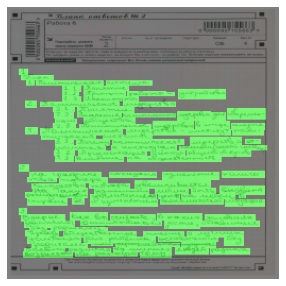

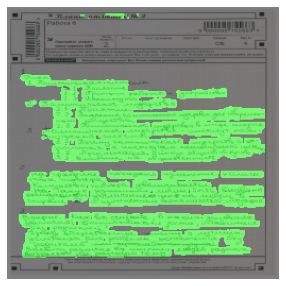

In [160]:
show_images_with_mask(0, False)
show_images_with_mask(0, True)